In [2]:
import pandas as pd     
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import torch
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'torch'

## 1 Load Data

In [2]:
# read train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# use to index the submittion file
PassengerId = test['PassengerId']

# process train and test dataset at the same time
all_data = pd.concat([train, test], ignore_index = True)

## 2 Analyse Data

### 2.1 overview

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 2.2 the relationships between every features and survival

In [5]:
# the number of survival and death
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

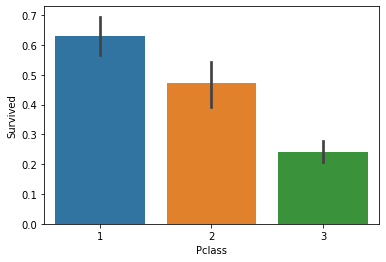

In [6]:
# Pclass：the higher the class, the higher the survival rate
sns.barplot(x = 'Pclass', y = 'Survived', data = train)

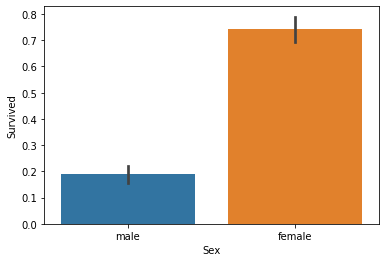

In [7]:
# Sex：female is more likely to survive than male
sns.barplot(x = 'Sex', y = 'Survived', data = train)

Text(12.359751157407416, 0.5, 'density')

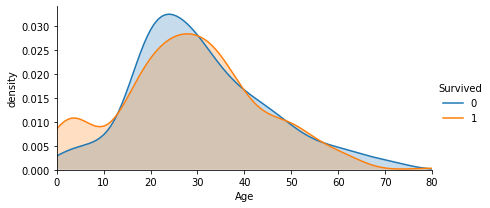

In [8]:
# Age：under 15-year-old there is an apparent differency of survival rate in the same age
facet = sns.FacetGrid(train, hue = 'Survived', aspect = 2)
facet.map(sns.kdeplot, 'Age', shade = True)
facet.set(Xlim = (0, train['Age'].max()))
facet.add_legend()
plt.xlabel('Age')
plt.ylabel('density')

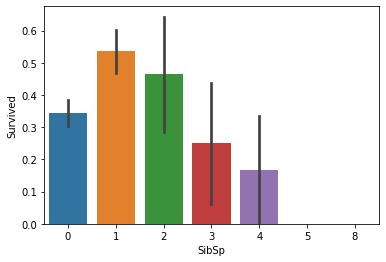

In [9]:
# SibSp：the more medium the number of sublings, the higher survival rate
sns.barplot(x = 'SibSp', y = 'Survived', data = train)

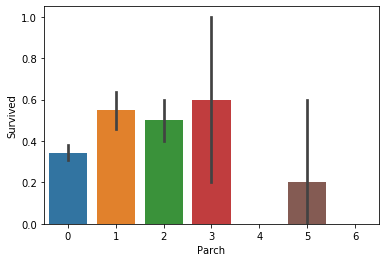

In [10]:
# Parch：the more medium the number of parents and children, the higher survival rate
sns.barplot(x = 'Parch', y = 'Survived', data = train)

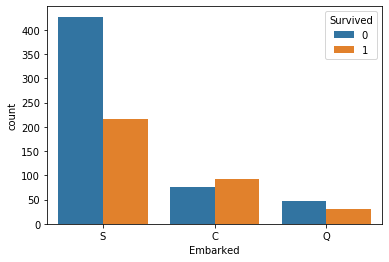

In [11]:
# Embarked：C has the highest survival rate
sns.countplot('Embarked', hue = 'Survived', data = train)

## 3 Process Data

### 3.1 create new features with name, family and ticket

In [12]:
# surname
all_data['Surname'] = all_data['Name'].apply(lambda x : x.split(',')[0].strip())

In [13]:
# Name Title
all_data['Title'] = all_data['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())
Title_Dict = {}
Title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Title_Dict.update(dict.fromkeys(['Master', 'Jonkheer'], 'Master'))

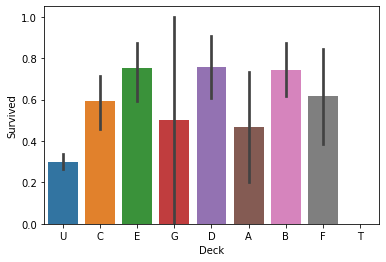

In [14]:
# show the deck using cabin number
# E D B is more likely to survive
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)
sns.barplot(x = 'Deck', y = 'Survived', data = all_data)

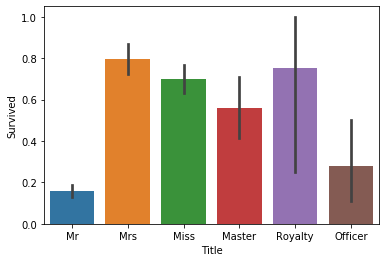

In [15]:
all_data['Title'] = all_data['Title'].map(Title_Dict)
sns.barplot(x = 'Title', y = 'Survived', data = all_data)

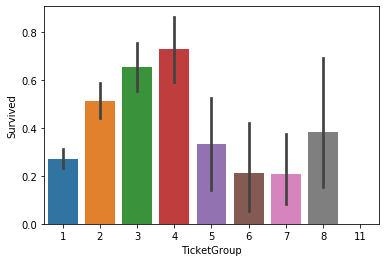

In [16]:
# TicketGroup
Ticket_Count = dict(all_data['Ticket'].value_counts())
all_data['TicketGroup'] = all_data['Ticket'].apply(lambda x : Ticket_Count[x])
sns.barplot(x = 'TicketGroup', y = 'Survived', data = all_data)

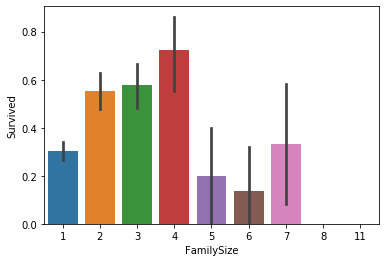

In [17]:
# FamilySize
all_data['FamilySize'] = all_data['SibSp'] + all_data['Parch'] + 1
sns.barplot(x = 'FamilySize', y = 'Survived', data = all_data)

In [18]:
# optimization 1st: IsAlone
all_data['IsAlone'] = 0
all_data.loc[all_data['FamilySize'] == 1, 'IsAlone'] = 1

### 3.2 fill missing values

In [19]:
# Age：the missing rate of Age is quite high, so use random forest to fill it based on Sex, Title and Pclass
all_data[all_data['Age'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone
5,NaN,Unknown,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,Moran,Mr,U,1,1,1
17,NaN,Unknown,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,male,0,1.0,244373,Williams,Mr,U,1,1,1
19,NaN,Unknown,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,female,0,1.0,2649,Masselmani,Mrs,U,1,1,1
26,NaN,Unknown,C,7.2250,"Emir, Mr. Farred Chehab",0,27,3,male,0,0.0,2631,Emir,Mr,U,1,1,1
28,NaN,Unknown,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,female,0,1.0,330959,O'Dwyer,Miss,U,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,NaN,Unknown,Q,7.7208,"Riordan, Miss. Johanna Hannah""""",0,1300,3,female,0,NaN,334915,Riordan,Miss,U,1,1,1
1301,NaN,Unknown,Q,7.7500,"Naughton, Miss. Hannah",0,1302,3,female,0,NaN,365237,Naughton,Miss,U,1,1,1
1304,NaN,Unknown,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,Spector,Mr,U,1,1,1
1307,NaN,Unknown,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Ware,Mr,U,1,1,1


In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
age_df = all_data[['Age', 'Pclass', 'Sex', 'Title', 'Parch']]
age_df = pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1:])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges

In [22]:
all_data[all_data['Age'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone


In [23]:
# optimization 1st: CatagoricalAge
all_data['CategoricalAge'] = pd.cut(all_data['Age'], 5)

In [24]:
# Embarked：only two missing values, and set to C according to Pclass，Embarked
all_data[all_data['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Icard,Miss,B,2,1,1,"(32.102, 48.068]"
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Stone,Mrs,B,2,1,1,"(48.068, 64.034]"


In [25]:
all_data.groupby(by = ['Pclass', 'Embarked']).Fare.median()

Pclass  Embarked
1       C           76.7292
        Q           90.0000
        S           52.0000
2       C           15.3146
        Q           12.3500
        S           15.3750
3       C            7.8958
        Q            7.7500
        S            8.0500
Name: Fare, dtype: float64

In [26]:
all_data['Embarked'] = all_data['Embarked'].fillna('C')

In [27]:
# Fare：there is only one missing value, and calculate the median value of fare according to Embarked and Pclass
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge
1043,60.5,Unknown,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,Storey,Mr,U,1,1,1,"(48.068, 64.034]"


In [28]:
fare = all_data[(all_data['Embarked'] == 'S') & (all_data['Pclass'] == 3)].Fare.median()
all_data['Fare'] = all_data['Fare'].fillna(fare)

In [29]:
all_data[all_data['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge


In [30]:
# optimization 1st: change to a new feature
all_data['CategoricalFare'] = pd.qcut(all_data['Fare'], 4)

In [31]:
all_data.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Surname,Title,Deck,TicketGroup,FamilySize,IsAlone,CategoricalAge,CategoricalFare
0,22.0,Unknown,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Braund,Mr,U,1,2,0,"(16.136, 32.102]","(-0.001, 7.896]"
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Cumings,Mrs,C,2,2,0,"(32.102, 48.068]","(31.275, 512.329]"
2,26.0,Unknown,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Miss,U,1,1,1,"(16.136, 32.102]","(7.896, 14.454]"


### 3.3 identity the same groups

### 3.4 show the correlations

In [32]:
# feature selection
#all_data=pd.concat([train, test])
all_data = all_data[['Survived', 'Pclass', 'Sex', 'CategoricalAge', 'CategoricalFare',
                     'Embarked', 'Title', 'IsAlone']]
all_data.head(3)

,Survived,Pclass,Sex,CategoricalAge,CategoricalFare,Embarked,Surname,Title,Deck,FamilySize,IsAlone,TicketGroup
0,0.0,3,male,"(16.136, 32.102]","(-0.001, 7.896]",S,Braund,Mr,U,2,0,1
1,1.0,1,female,"(32.102, 48.068]","(31.275, 512.329]",C,Cumings,Mrs,C,2,0,2
2,1.0,3,female,"(16.136, 32.102]","(7.896, 14.454]",S,Heikkinen,Miss,U,1,1,1


In [33]:
# change to category then to numerical
for feature in ['Sex', 'Embarked', 'Title', 'CategoricalAge', 'CategoricalFare']:
    all_data[feature] = all_data[feature].astype('category')
    all_data[feature] = pd.DataFrame({feature: all_data[feature].cat.codes}, index=all_data[feature].index)

In [34]:
all_data.head(3)

,Survived,Pclass,Sex,CategoricalAge,CategoricalFare,Embarked,Surname,Title,Deck,FamilySize,IsAlone,TicketGroup
0,0.0,3,1,1,0,2,100,2,8,2,0,1
1,1.0,1,0,2,3,0,182,3,2,2,0,2
2,1.0,3,0,1,1,2,329,1,8,1,1,1


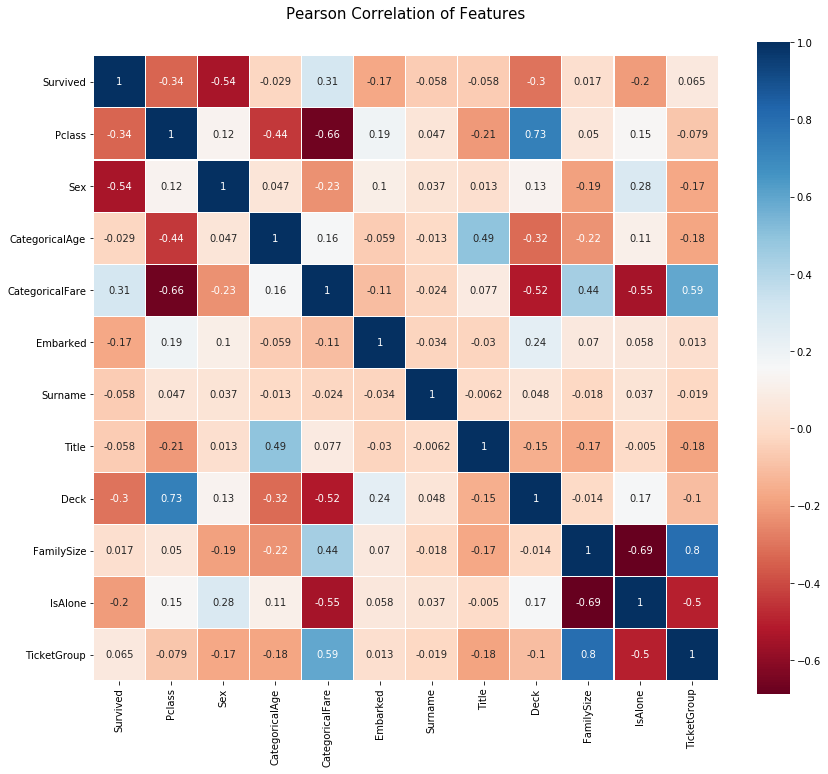

In [35]:
# correlation map
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(all_data.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### 3.5 transform features

In [36]:
import torch

train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived', axis = 1)
test = test.values
X = train.values[:, 1:]
y = train.values[:, 0].reshape((-1, 1))

X = torch.from_numpy(X)
y = torch.from_numpy(y)
test = torch.from_numpy(test)

kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2021).split(X, y)

testset = TensorDataset(test)
test_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=4)

In [37]:
print(X[:3], y[:3])

## 4 Build Model

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(7, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        out = self.hidden(x)
        return out

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
def train_epoch(net, data_loader, criterion, optimizer, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).float()

        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        prediction = (output > 0.5).int()
        correct += (prediction == target).sum().item()
        sample_num += len(data)
    
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, criterion, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).float()

            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = (output > 0.5).int()
            correct += (prediction == target).sum().item()
            sample_num += len(data)
        
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc


In [ ]:
from tqdm import tqdm

fold_train_loss_list = []
fold_train_acc_list = []
fold_val_loss_list = []
fold_val_acc_list = []

for n_fold,(train_idx, val_idx) in enumerate(kFold):
    # get i-fold
    trainset = TensorDataset(X[train_idx], y[train_idx])
    train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
    valset = TensorDataset(X[val_idx], y[val_idx])
    val_loader = DataLoader(valset, batch_size=32, shuffle=True, num_workers=4)
    
    # define a new net
    net = myModel().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=1, verbose=True, min_lr=1e-8)

    # train at this fold
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    torch.cuda.empty_cache()

    EPOCHS = 50
    BEST_ACC = 0
    
    print('Fold %d:' % n_fold)
    for epoch in range(EPOCHS):
        tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
        train_loss, train_acc = train_epoch(net, tk, criterion, optimizer, device)

        tk = tqdm(val_loader, total=len(val_loader), position=0, leave=True)
        val_loss, val_acc = test_epoch(net, tk, criterion, device)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        if val_acc > BEST_ACC:
            BEST_ACC = val_acc
            dirr = './weights/fold' + str(n_fold) + '_weight_' + str(round(BEST_ACC, 4)) + '.pt'
            torch.save(net.state_dict(), dirr)

        print('epoch %d, train loss %.4lf, train acc %.4lf, test loss %.4lf, test acc %.4lf, , best acc %.4lf' %
        (epoch + 1, train_loss, train_acc, val_loss, val_acc, BEST_ACC))

        scheduler.step(val_acc)
    
    fold_train_loss_list.append(train_loss_list)
    fold_train_acc_list.append(train_acc_list)
    fold_val_loss_list.append(val_loss_list)
    fold_val_acc_list.append(val_acc_list)


In [ ]:
for i in range(10):
    plt.figure(figsize=[20,9])
    plt.plot(fold_train_loss_list[i],label="train_loss",color="red")
    plt.plot(fold_train_acc_list[i],label="train_acc",color="orange")
    plt.plot(fold_val_loss_list[i],label="val_loss",color="blue")
    plt.plot(fold_val_acc_list[i],label="val_acc",color="green")
    plt.legend()

## 5 Predict Data

In [51]:
# predict = model.predict(test)
# predict = (predict > 0.5).astype(int).ravel()

# submission = pd.DataFrame({'PassengerId' : PassengerId, 'Survived' : predict.astype(np.int32)})
# submission.to_csv(r"submission1.csv", index = False)

In [ ]:
# Y_pred_rand = (model.predict(X) > 0.5).astype(int)
# print('Precision : ', np.round(metrics.precision_score(y, Y_pred_rand)*100,2))
# print('Accuracy : ', np.round(metrics.accuracy_score(y, Y_pred_rand)*100,2))
# print('Recall : ', np.round(metrics.recall_score(y, Y_pred_rand)*100,2))
# print('F1 score : ', np.round(metrics.f1_score(y, Y_pred_rand)*100,2))
# print('AUC : ', np.round(metrics.roc_auc_score(y, Y_pred_rand)*100,2))